In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler

from scipy.optimize import curve_fit

settings_path = 'settings/tropics.yaml'

In [3]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
# jd = joint_distrib.JointDistribution(gr)

if __name__ == '__main__':
    # print("Loaded Configuration:")
    # for key, value in settings.items():
    #     print(f"{key}: {value}")
    
    #gr.compute_funcs_for_var_id()
    pass


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


## Retrieve storms object


In [4]:
jd = joint_distrib.JointDistribution(gr, nd=5, storm_tracking=True)

Distribs loaded
Overwrite set to false so loading basics attributes from .npy
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


## 100 in one plot

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


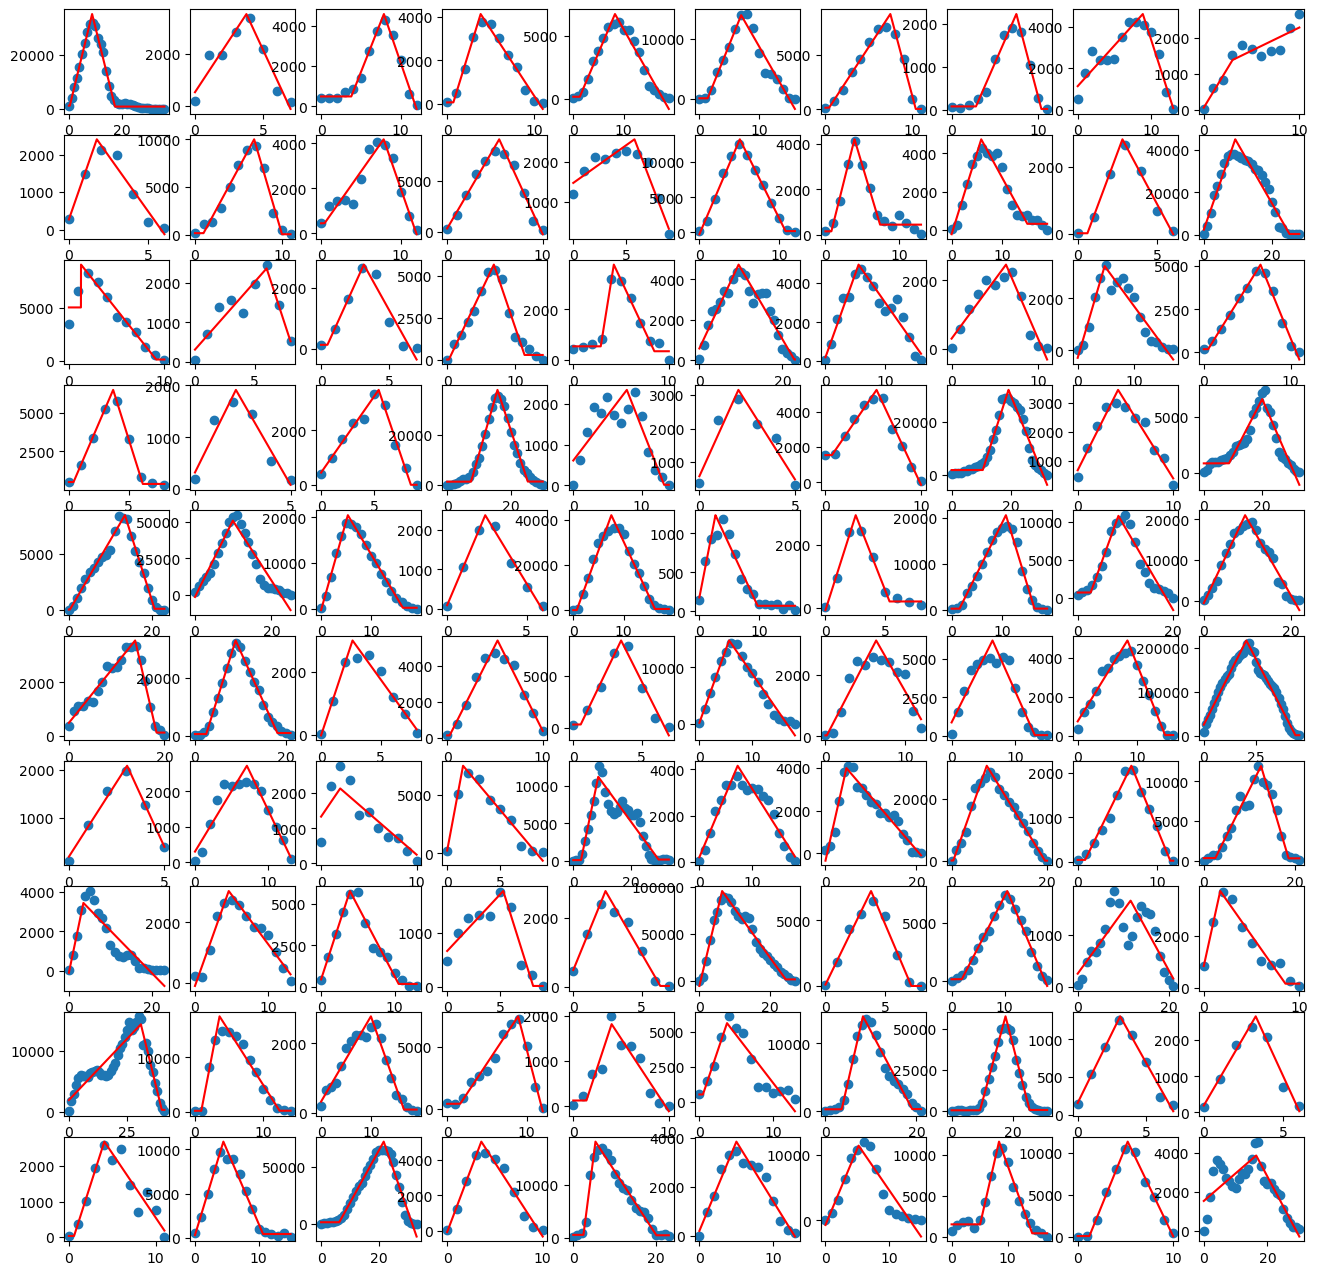

In [14]:
import random 

def piecewise_linear(t:np.array,t_breaks:list,s_breaks:list):
    """
    Define piecewise linear RH shape with constant value at top and bottom.

    Args:
        t (np.array): t coordinate
        t_breaks (list): t values of break points
        s_breaks (list): surface values of break points

    Returns:
        np.array: piecewize surface
        
    """
    
    N_breaks = len(t_breaks)
    
    cond_list = [t <= t_breaks[0]]+\
                [np.logical_and(t > t_breaks[i-1],t <= t_breaks[i]) for i in range(1,N_breaks)]+\
                [t > t_breaks[N_breaks-1]]
                
    def make_piece(k):
        def f(t):
            return s_breaks[k-1]+(s_breaks[k]-s_breaks[k-1])/(t_breaks[k]-t_breaks[k-1])*(t-t_breaks[k-1])
        return f 
    func_list = [lambda t: s_breaks[0]]+\
                [make_piece(k) for k in range(1,N_breaks)]+\
                [lambda t: s_breaks[N_breaks-1]]
                
    return np.piecewise(t,cond_list,func_list)

def piecewise_fit(t:np.array,s:np.array,t_breaks_0:list,s_breaks_0:list):    
    """
    Compute piecewise-linear fit of surf(t).

    Args:
        t (np.array): t coordinate
        s (np.array): surface over time
        t_breaks_0 (list): initial t values of break points
        s_breaks_0 (list): initial s values of break points

    Returns:
        t_breaks (list): fitted t values of break points
        s_breaks (list): fitted s values of break points
        s_id (np.array): piecewize s fit

    """

    N_breaks = len(t_breaks_0)

    def piecewise_fun(t,*p):
        return piecewise_linear(t,p[0:N_breaks],p[N_breaks:2*N_breaks])

    p , e = curve_fit(piecewise_fun, t, s, p0=t_breaks_0+s_breaks_0)

    s_id = piecewise_linear(t, p[0:N_breaks], p[N_breaks:2*N_breaks])
    s_breaks = list(p[N_breaks:2*N_breaks])
    t_breaks = list(p[0:N_breaks])
    
    return t_breaks,s_breaks,s_id


rand_i = random.sample(range(len(jd.label_storms)), 100)
fig, axs = plt.subplots(nrows=10, ncols = 10, figsize=(16, 16))
for ax, i_label  in zip(axs.flatten(), rand_i):
    storm = jd.storms[i_label]
    surf = np.array(storm.clusters.surfPix_172Wm2)*16 
    time = np.arange(0, len(surf))

    # Initial guess
    surf_breaks = [0, max(surf), 0]
    time_breaks = [0, len(surf)//2, len(surf)]

    # Fit the piecewise linear function to the data
    t_breaks, s_breaks, s_id = piecewise_fit(time, surf, time_breaks, surf_breaks)

    # Plotting the results
    ax.scatter(time, surf, label='Surface')
    time_plot = np.linspace(0, time.max(), 1000)
    ax.plot(time_plot, piecewise_linear(time_plot, t_breaks, s_breaks), 'r-', label='Idealized Surface')
plt.show()

## Plot over and over to see r score

For storm with label 189229 the growth_rate computed by fitting a triangle is 92.59363865506587 with a r-score of 0.50972765630093


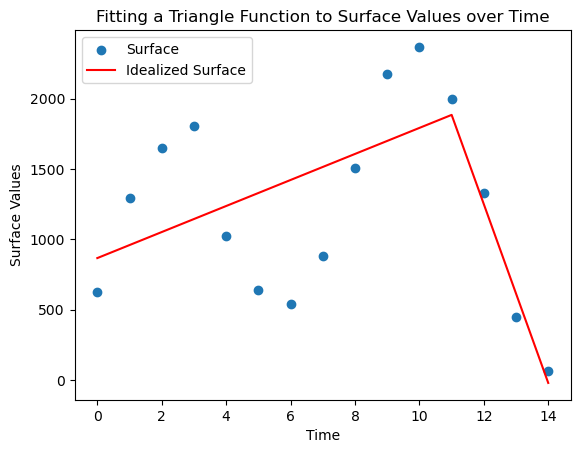

In [55]:
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import random 

i = random.randint(0, len(jd.storms))
storm = jd.storms[i]

def piecewise_linear(t:np.array,t_breaks:list,s_breaks:list):
    """
    Define piecewise linear RH shape with constant value at top and bottom.

    Args:
        t (np.array): t coordinate
        t_breaks (list): t values of break points
        s_breaks (list): surface values of break points

    Returns:
        np.array: piecewize surface
        
    """
    
    N_breaks = len(t_breaks)
    
    cond_list = [t <= t_breaks[0]]+\
                [np.logical_and(t > t_breaks[i-1],t <= t_breaks[i]) for i in range(1,N_breaks)]+\
                [t > t_breaks[N_breaks-1]]
                
    def make_piece(k):
        def f(t):
            return s_breaks[k-1]+(s_breaks[k]-s_breaks[k-1])/(t_breaks[k]-t_breaks[k-1])*(t-t_breaks[k-1])
        return f 
    func_list = [lambda t: s_breaks[0]]+\
                [make_piece(k) for k in range(1,N_breaks)]+\
                [lambda t: s_breaks[N_breaks-1]]
                
    return np.piecewise(t,cond_list,func_list)

def piecewise_fit(t:np.array,s:np.array,t_breaks_0:list,s_breaks_0:list):    
    """
    Compute piecewise-linear fit of surf(t).

    Args:
        t (np.array): t coordinate
        s (np.array): surface over time
        t_breaks_0 (list): initial t values of break points
        s_breaks_0 (list): initial s values of break points

    Returns:
        t_breaks (list): fitted t values of break points
        s_breaks (list): fitted s values of break points
        s_id (np.array): piecewize s fit

    """

    N_breaks = len(t_breaks_0)

    def piecewise_fun(t,*p):
        return piecewise_linear(t,p[0:N_breaks],p[N_breaks:2*N_breaks])

    p , e = curve_fit(piecewise_fun, t, s, p0=t_breaks_0+s_breaks_0)

    s_id = piecewise_linear(t, p[0:N_breaks], p[N_breaks:2*N_breaks])
    s_breaks = list(p[N_breaks:2*N_breaks])
    t_breaks = list(p[0:N_breaks])
    
    return t_breaks,s_breaks,s_id

surf = np.array(storm.clusters.surfPix_172Wm2) * 16
time = np.arange(0, len(surf))

# Initial guess
surf_breaks = [0, max(surf), 0]
time_breaks = [0, len(surf)//2, len(surf)]

# Fit the piecewise linear function to the data
t_breaks, s_breaks, s_id = piecewise_fit(time, surf, time_breaks, surf_breaks)
r_squared = r2_score(surf, s_id)
growth_rate = (s_breaks[1]- s_breaks[0]) / (t_breaks[1] - t_breaks[0])
print(f"For storm with label {i} the growth_rate computed by fitting a triangle is {growth_rate} with a r-score of {r_squared}")

# Plotting the results
plt.scatter(time, surf, label='Surface')
time_plot = np.linspace(0, time.max(), 1000)
plt.plot(time_plot, piecewise_linear(time_plot, t_breaks, s_breaks), 'r-', label='Idealized Surface')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Surface Values')

plt.title('Fitting a Triangle Function to Surface Values over Time')
plt.show()

# Vanilla


In [43]:
data, noise = jd.get_mcs_bin_fraction()

In [44]:
# i_label = 30
# surf_km2 = jd.storms[i_label].surfmaxkm2_172Wm2
# surf_pix2 = np.max(jd.storms[i_label].clusters.surfPix_172Wm2)
# print(surf_km2/surf_pix2)

def growth_rate(mcs_list, label_list):
    def idx_by_label(labels, label_list):
        idxs = [label_list.index(label) for label in labels]
        return idxs
    
    def calculate_first_derivative(time_series, time_step = 30):
        """
        Calculate the first derivative of a time series using the central difference method.

        Parameters:
        time_series (np.array): A 1D numpy array representing the surface of an object over time.
        time_step (float): The time interval between successive samples in the time series.

        Returns:
        derivative (np.array): A 1D numpy array representing the first derivative of the time series.
        """
        n = len(time_series)
        derivative = np.zeros(n)

        # Calculate the central difference method
        for i in range(1, n-1):
            derivative[i] = (time_series[i+1] - time_series[i-1]) / (2*time_step)

        # Apply forward difference at the start and backward difference at the end
        derivative[0] = (time_series[1] - time_series[0]) / time_step
        derivative[n-1] = (time_series[n-1] - time_series[n-2]) / time_step

        # Robustness check for stability
        derivative[np.isnan(derivative)] = 0.0
        derivative[np.isinf(derivative)] = 0.0

        return derivative
    
    def classify_derivative(derivative):
        """
        Classify a derivative array based on its positiveness.

        Parameters:
        derivative (np.array): A 1D numpy array representing the derivative of a time series.

        Returns:
        classification (int): A flag indicating the classification of the derivative.
        """
        # Step 1: Calculate the array of positiveness flags
        positiveness = np.zeros_like(derivative)
        positiveness[derivative >= 0] = 1  # positive derivative
        positiveness[derivative < 0] = -1  # negative derivative

        # Step 2: Classify the derivative based on its positiveness and length
        classification = 0
        length = len(derivative)
        positive_periods = []
        negative_periods = []

        if length < 10:
            # Case 1: Length is lower than 10
            classification = 1

        else:
            # Case 2: Length is 10 or greater
            if positiveness[0] > 0:
                # Start of a positive period
                positive_periods.append(0)
            for i in range(1, length):
                if positiveness[i] > 0 and positiveness[i-1] <= 0:
                    # Start of a positive period
                    positive_periods.append(i)
                elif positiveness[i] < 0 and positiveness[i-1] >= 0:
                    # Start of a negative period
                    negative_periods.append(i)

            if len(positive_periods) > 1 and len(negative_periods) != 0:
                # First period is negative
                classification = 2.1
            else :
                classification = 2

        return classification, positive_periods, negative_periods
    
    assert len(label_list)==len(mcs_list)
    growth_rate_list = []
    for mcs in mcs_list:
        surf = np.array(mcs.clusters.surfPix_172Wm2)*16 #That's the ratio between a pixel surf and the surf of Amax
        dsurf = calculate_first_derivative(surf)
        mclass, pos, neg = classify_derivative(dsurf)
        if (mclass==2) or mclass == 1 :
            growth_rate_list.append(np.nanmean(dsurf[dsurf>0]))
            #if (dsurf>0).any() == False : print(MCSs[i].label) #16221 17756 22397
        elif mclass==2.1:
            growth_rate_list.append(np.nanmean(dsurf[pos[0]:neg[0]]))
        
    return growth_rate_list

In [45]:
storms_growth_rate = growth_rate(jd.storms, jd.label_storms)
for i,storm in enumerate(jd.storms):
    storm.growth_rate = storms_growth_rate[i]
    
# i = 1
# print(jd.storms[i].growth_rate)
# plt.plot(16*np.array(jd.storms[i].clusters.surfPix_172Wm2))

/scratchx/mcarenso/ipykernel_3250478/3704557198.py:92: RuntimeWarning: Mean of empty slice
  growth_rate_list.append(np.nanmean(dsurf[dsurf>0]))


In [46]:
mean_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['mean'])
max_growth_rate = jd.storm_attributes_on_jdist(['growth_rate'], ['max'])

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

In [47]:
mean_growth_rate = mean_growth_rate[0][0,0,:,:]
max_growth_rate = max_growth_rate[0][0,0,:,:]

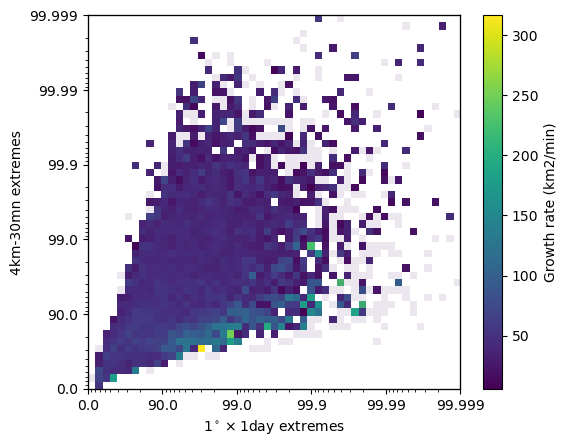

In [48]:
data = mean_growth_rate
jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (km2/min)')

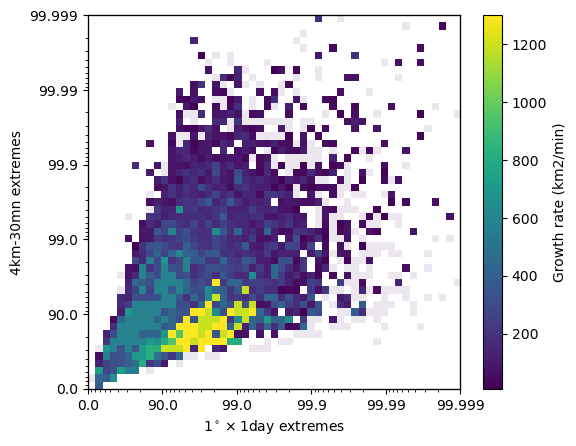

In [49]:
data = max_growth_rate
jd.plot_data(data, noise, cmap = plt.cm.viridis, branch=False, label = 'Growth rate (km2/min)')